# Data Analysis Template

***

## Project Description

And that is exactly what your Accenture team lead asked you to focus on for this task: analyse shopper order data from Everqlo’s e-commerce site and draw interesting insights.  

Specifically, they want you to answer the following:

    What age group used BNPL option most?
    What is the share of transaction amount that BNPL accounted for?
    What is the average age of a customer that used a BNPL option?


## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero, median, mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import datetime
from datetime import datetime, timedelta

# import eli5
# from IPython.display import display

#import os
#import zipfile
import scipy.stats
from collections import Counter

import sklearn
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
# from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
# from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

# from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor, plot_tree
# from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
# from sklearn.naive_bayes import GaussianNB, MultinomialNB

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# Use Feature-Engine library
import feature_engine
#from feature_engine import imputation as mdi
#from feature_engine.outlier_removers import Winsorizer
#from feature_engine import categorical_encoders as ce
from feature_engine.discretisation import EqualWidthDiscretiser, EqualFrequencyDiscretiser
#from feature_engine.discretisation import ArbitraryDiscretiser, DecisionTreeDiscretiser
#from feature_engine.encoding import OrdinalEncoder

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("BNPLDataset.csv")

In [3]:
df

,order_ref,user_id,user_age,transaction_amount,payment_method
0,1132281533,I0rmuuMuhEvJNM57,34,184.34,card
1,3969891453,qS2JZuEAEDsOP2Gx,50,342.49,bnpl
2,4151458626,RpV4Uu1dEszTCOEM,47,146.51,bnpl
3,4700675226,AoYuzIJEZAwd9lXh,26,223.25,bnpl
4,7889678320,IO4MB7PVS9sS4k1I,34,92.52,card
...,...,...,...,...,...
294,3118785229,XB19WIBaxPQFmPct,28,234.22,paypal
295,6652908609,xiZu8kDPGMsEuuhg,39,90.69,bnpl
296,4547464795,ccsFZwawm475aTiw,24,210.43,paypal
297,6752905764,9V5cb1KKRXigAt2E,25,137.26,paypal


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_ref           299 non-null    int64  
 1   user_id             299 non-null    object 
 2   user_age            299 non-null    int64  
 3   transaction_amount  299 non-null    float64
 4   payment_method      299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [5]:
df.describe()

,order_ref,user_age,transaction_amount
count,299.00,299.00,299.00
mean,5640904908.39,32.33,214.08
std,2645583783.86,10.08,76.85
min,1012455468.00,18.00,83.21
25%,3395444621.00,23.00,146.51
50%,5775407496.00,33.00,218.11
75%,7951906970.00,41.00,275.84
max,9957238682.00,50.00,348.82


In [6]:
df.columns

Index(['order_ref', 'user_id', 'user_age', 'transaction_amount', 'payment_method'], dtype='object')

### Drop unwanted features

In [7]:
df.drop(['order_ref', 'user_id'], axis=1, inplace=True)

### Treat Missing Values

In [8]:
df.isnull().sum()

user_age              0
transaction_amount    0
payment_method        0
dtype: int64

### Equal Frequency Discretizer

In [9]:
df["age_cat"] = df["user_age"] #Make a copy

In [10]:
disc = EqualFrequencyDiscretiser(q=5, variables=['age_cat'])

In [11]:
disc.fit(df)

EqualFrequencyDiscretiser(q=5, variables=['age_cat'])

In [12]:
disc.binner_dict_

{'age_cat': [-inf, 22.0, 26.0, 36.0, 43.0, inf]}

In [13]:
df2 = disc.transform(df)
df2.head()

,user_age,transaction_amount,payment_method,age_cat
0,34,184.34,card,2
1,50,342.49,bnpl,4
2,47,146.51,bnpl,4
3,26,223.25,bnpl,1
4,34,92.52,card,2


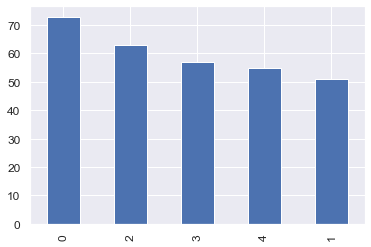

In [14]:
df2["age_cat"].value_counts().plot.bar()
plt.show()

In [15]:
bnpl = df2[df2["payment_method"] == "bnpl"]

### Groupby Function

In [16]:
bnpl.groupby(["age_cat"])["transaction_amount"].sum()

age_cat
0   10683.44
1    8049.50
2    1994.09
3    2555.10
4    1828.11
Name: transaction_amount, dtype: float64

In [17]:
bar_chart = pd.DataFrame(bnpl.groupby(["age_cat"])["transaction_amount"].sum())

In [18]:
bar_chart

,transaction_amount
age_cat,
0,10683.44
1,8049.50
2,1994.09
3,2555.10
4,1828.11


## Data Visualization

### Univariate Data Exploration

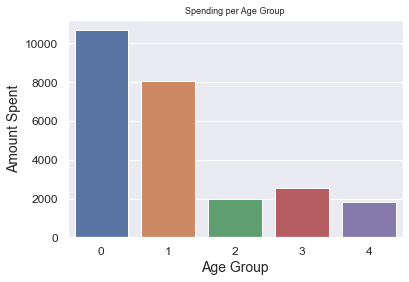

In [19]:
sns.barplot(x=bar_chart.index, y="transaction_amount", data=bar_chart, ci=None)
plt.title('Spending per Age Group')
#plt.xticks('x', labelrotation=45)
plt.xlabel("Age Group")
plt.ylabel("Amount Spent")

plt.show()

#### Python code done by Dennis Lam